In [1]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.stats import pearsonr

In [52]:
df = pd.read_csv('./csv/travistorrent_8_2_2017.csv')

In [53]:
# Dropping useless columns
df = df.drop(
        ["tr_build_number", "git_branch", "gh_is_pr", "git_merged_with", "gh_pull_req_num",
         "gh_commits_in_push", "git_prev_commit_resolution_status", "git_prev_built_commit", "tr_prev_build",
         "git_all_built_commits", "git_trigger_commit", "tr_virtual_merged_into", "tr_original_commit", "tr_jobs"],
        axis=1)

In [54]:
# Convert gh_pushed_at and gh_first_commit_created_at to delta time
df['gh_pushed_at'] = pd.to_datetime(df['gh_pushed_at'])
df['gh_first_commit_created_at'] = pd.to_datetime(df['gh_first_commit_created_at'])

In [55]:
# Get date diff from them
df['date_diff'] = df['gh_pushed_at'].sub(df['gh_first_commit_created_at'], axis=0)
df["date_diff"] = df["date_diff"] / np.timedelta64(1, 'm')

In [56]:
# Map gh_by_core_team_member to 0 and 1
df['gh_by_core_team_member'] = df['gh_by_core_team_member'].map({True: 1, False: 0})

In [57]:
# Dropping rows where travis status is canceled or started and mapping the rest to 0 and 1
df = df[df.tr_status != 'canceled']
df = df[df.tr_status != 'started']
df['tr_status'] = df['tr_status'].map({'passed': 1, 'failed': 0, 'errored': 0})

In [58]:
# Source and test code ratio and their ratio over time
df["src_diff_ratio"] = df["git_diff_src_churn"] / df["gh_sloc"]
df["src_date"] = df["src_diff_ratio"] / df["date_diff"]
df["test_diff_ratio"] = df["git_diff_test_churn"] / df["gh_sloc"]
df["test_date"] = df["test_diff_ratio"] / df["date_diff"]

In [70]:
df.replace('', np.nan, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [71]:
df.dtypes

tr_build_id                                 int64
gh_project_name                            object
gh_pr_created_at                           object
gh_lang                                    object
gh_num_commits_in_push                    float64
gh_first_commit_created_at         datetime64[ns]
gh_team_size                                int64
git_num_all_built_commits                   int64
gh_num_issue_comments                     float64
gh_num_commit_comments                      int64
gh_num_pr_comments                        float64
git_diff_src_churn                          int64
git_diff_test_churn                         int64
gh_diff_files_added                         int64
gh_diff_files_deleted                       int64
gh_diff_files_modified                      int64
gh_diff_tests_added                         int64
gh_diff_tests_deleted                       int64
gh_diff_src_files                           int64
gh_diff_doc_files                           int64


In [59]:
df = df.sort_values('gh_team_size')

In [60]:
team_size = df.gh_team_size.unique()
print(team_size)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210
 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228
 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246
 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264
 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282
 283 284 285 286 287 288]


(array([3.323329e+06, 2.282020e+05, 4.798000e+04, 3.781200e+04,
        2.213900e+04, 2.720000e+02, 1.490000e+03, 3.320000e+02,
        2.320000e+02, 3.440000e+02]),
 array([3.0000000e+00, 1.3794930e+05, 2.7589560e+05, 4.1384190e+05,
        5.5178820e+05, 6.8973450e+05, 8.2768080e+05, 9.6562710e+05,
        1.1035734e+06, 1.2415197e+06, 1.3794660e+06]),
 <a list of 10 Patch objects>)

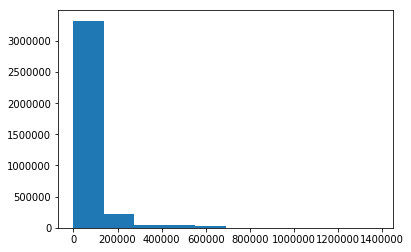

In [61]:
plt.hist(df["gh_sloc"], bins=10)

(array([2584468.,  529057.,   39282.,   40417.,       0.,       0.,
          50792.,  342966.,   64517.,   10633.]),
 array([  0. ,  28.8,  57.6,  86.4, 115.2, 144. , 172.8, 201.6, 230.4,
        259.2, 288. ]),
 <a list of 10 Patch objects>)

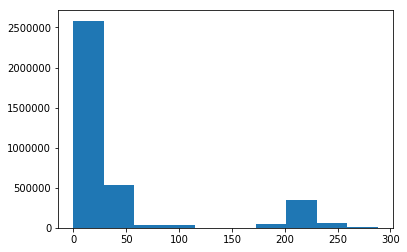

In [62]:
plt.hist(df["gh_team_size"], bins=10)

(array([3.662124e+06, 5.000000e+00, 0.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([      0. ,  527826.3, 1055652.6, 1583478.9, 2111305.2, 2639131.5,
        3166957.8, 3694784.1, 4222610.4, 4750436.7, 5278263. ]),
 <a list of 10 Patch objects>)

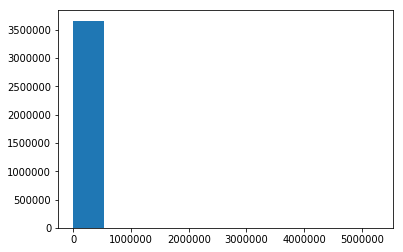

In [63]:
plt.hist(df["git_diff_src_churn"], bins=10)

(array([3.66204e+06, 5.10000e+01, 2.30000e+01, 5.00000e+00, 5.00000e+00,
        0.00000e+00, 5.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([     0. ,  39349.5,  78699. , 118048.5, 157398. , 196747.5,
        236097. , 275446.5, 314796. , 354145.5, 393495. ]),
 <a list of 10 Patch objects>)

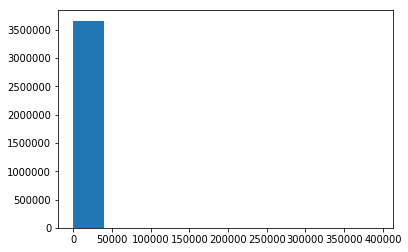

In [64]:
plt.hist(df["git_diff_test_churn"], bins=10)

(array([1.000000e+00, 7.900000e+01, 2.902758e+06, 1.390000e+02,
        4.300000e+01, 1.200000e+01, 2.000000e+00, 2.000000e+00,
        0.000000e+00, 1.100000e+01]),
 array([-147.        ,  -77.63333333,   -8.26666667,   61.1       ,
         130.46666667,  199.83333333,  269.2       ,  338.56666667,
         407.93333333,  477.3       ,  546.66666667]),
 <a list of 10 Patch objects>)

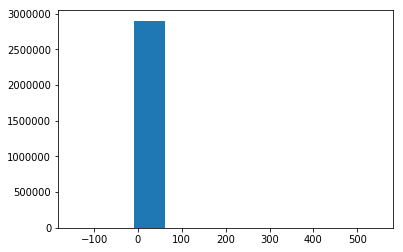

In [72]:
plt.hist(df["src_date"], bins=10)

(array([1.400000e+01, 2.902762e+06, 2.350000e+02, 2.700000e+01,
        4.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 4.000000e+00]),
 array([-69.05982906, -25.77884615,  17.50213675,  60.78311966,
        104.06410256, 147.34508547, 190.62606838, 233.90705128,
        277.18803419, 320.46901709, 363.75      ]),
 <a list of 10 Patch objects>)

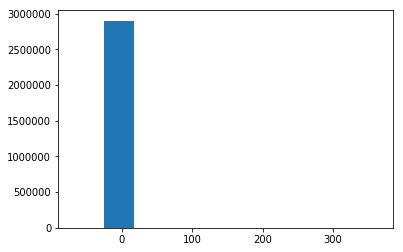

In [73]:
plt.hist(df["test_date"], bins=10)

(array([2.883347e+06, 2.273700e+04, 5.953000e+03, 1.652000e+03,
        6.970000e+02, 2.480000e+02, 6.300000e+01, 1.100000e+01,
        2.000000e+00, 9.000000e+00]),
 array([  -5703.3  ,  291034.945,  587773.19 ,  884511.435, 1181249.68 ,
        1477987.925, 1774726.17 , 2071464.415, 2368202.66 , 2664940.905,
        2961679.15 ]),
 <a list of 10 Patch objects>)

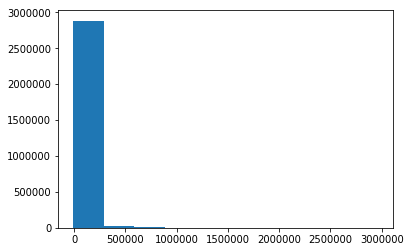

In [74]:
plt.hist(df["date_diff"], bins=10)

In [79]:
subdf = df.loc[df['gh_team_size'] < 60]
team_size2 = subdf.gh_team_size.unique()

In [83]:
d = np.array(subdf.groupby('gh_team_size', as_index=False)['date_diff'].mean()["date_diff"].tolist(), dtype=np.float)
stats.spearmanr(team_size2, d)

SpearmanrResult(correlation=-0.4653514865240346, pvalue=0.00017935171424133953)

In [82]:
s = np.array(subdf.groupby('gh_team_size', as_index=False)['src_date'].mean()["src_date"].tolist(), dtype=np.float)
stats.spearmanr(team_size2, s)

SpearmanrResult(correlation=-0.7203667685468187, pvalue=8.677774176106167e-11)

In [84]:
s = np.array(subdf.groupby('gh_team_size', as_index=False)['test_date'].mean()["test_date"].tolist(), dtype=np.float)
stats.spearmanr(team_size2, s)

SpearmanrResult(correlation=-0.8134481800500141, pvalue=2.845975735065003e-15)

In [85]:
s = np.array(subdf.groupby('gh_team_size', as_index=False)['src_diff_ratio'].mean()["src_diff_ratio"].tolist(), dtype=np.float)
stats.spearmanr(team_size2, s)

SpearmanrResult(correlation=-0.7210336204501252, pvalue=8.181651679391172e-11)

In [86]:
s = np.array(subdf.groupby('gh_team_size', as_index=False)['test_diff_ratio'].mean()["test_diff_ratio"].tolist(), dtype=np.float)
stats.spearmanr(team_size2, s)

SpearmanrResult(correlation=-0.6605168102250627, pvalue=9.339952208284393e-09)

In [87]:
ok = np.array(subdf.groupby('gh_team_size', as_index=False)['tr_log_num_tests_ok'].mean()["tr_log_num_tests_ok"].tolist(), dtype=np.float)
run = np.array(subdf.groupby('gh_team_size', as_index=False)['tr_log_num_tests_run'].mean()["tr_log_num_tests_run"].tolist(), dtype=np.float)
stats.spearmanr(team_size2, ok / run)

SpearmanrResult(correlation=0.0010002778549597113, pvalue=0.993948001796065)

In [88]:
fail = np.array(subdf.groupby('gh_team_size', as_index=False)['tr_log_num_tests_failed'].mean()["tr_log_num_tests_failed"].tolist(), dtype=np.float)
stats.spearmanr(team_size2, fail / run)

SpearmanrResult(correlation=-0.34915254237288146, pvalue=0.006252063659835836)